## Naive Bayes Classifier

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

### Implement Naive Bayes classifier in python from scratch

In [2]:
class NaiveBayes:

    """
    The NaiveBayes class which can handle mixed data types.

    Parameters:
    ----------
    nb_type (str) [required]: Naive Bayes type. It can be any one of the following:
        - "gaussian": It is used when the features in the data is numerical and normally distributed. 
        - "categorical": It is used when the features in the data is categorical.
        - "bernoulli": It is used when the features in the data is boolean.
        - "mixed": It is used when the features in the data is of mixed type.

    feature_types (dict) [required]: A dictionary where 'key' is the type of variable and 'value' is the list 
                          of features having that particular data type.
        The key can be either "numerical", "categorical", "boolean"
        example:
        {"numerical": ['feature1', 'feature4', 'feature5'],
         "categorical": ['feature2', 'feature6'],
         "boolean": ['feature3']
        }
        It is used along with `nb_type` to determine which features to use for which type of naive bayes.
        If `nb_type == 'gaussian'` then only numerical features will be used.
        If `nb_type == 'categorical'` then only categorical features will be used.
        If `nb_type == 'bernoulli'` then only boolean features will be used.
        If `nb_type == 'mixed'` then all types of features will be used.

    alpha (float) [optional]: Smoothing parameter used for 'categorical' and 'bernoulli' naive bayes.
        alpha >= 0. Default is 1.
        For numerical stability alpha is set to 1e-6 if user provided alpha value is 0.
        If alpha = 1, it is called Laplace Smoothing. If 0 < alpha < 1, it is called Lidstone Smoothing. 
    """

    def __init__(self, nb_type, feature_types, alpha=1):
        
        if nb_type not in ["gaussian", "categorical", "bernoulli", "mixed"]:
            raise ValueError("`nb_types` should be any one from the list: ['gaussian', 'categorical', 'bernoulli', 'mixed']")
        else:
            self.nb_type = nb_type

        if feature_types is None:
            raise ValueError("feature_type should be provided")
        else:
            self.numerical_features = feature_types.get("numerical", [])
            self.categorical_features = feature_types.get("categorical", [])
            self.boolean_features = feature_types.get("boolean", [])
        
        if nb_type == "gaussian":
            if len(self.numerical_features) == 0:
                raise ValueError("numerical features should be provided if nb_type is gaussian")
            else:
                # making other features lists empty
                self.categorical_features = []
                self.boolean_features = []
        
        if nb_type == "categorical":
            if len(self.categorical_features) == 0:
                raise ValueError("categorical features should be provided if nb_type is categorical")
            else:
                # making other features lists empty
                self.numerical_features = []
                self.boolean_features = []

        if nb_type == "bernoulli":
            if len(self.boolean_features) == 0:
                raise ValueError("boolean features should be provided if nb_type is bernoulli")
            else:
                # making other features lists empty
                self.numerical_features = []
                self.categorical_features = []
            
        if alpha < 0:
            raise ValueError("alpha should be >= 0")
        elif alpha == 0:
            self.alpha = 1e-6
        else:
            self.alpha = alpha

        self.is_fit = False  # determines whether the model is already fitted or not

    def fit(self, X, y):
        """
        X is a pandas dataframe.
        The labels 'y' is expected to be label encoded.
        The boolean features of X are expected to be encoded in either 1 or 0.
        The categorical features of X are expected to be ordinal encoded.
        The numerical feature of X are expected to be standardized for better performance, but that is optional.  
        """
        self.n_samples, self.n_features = X.shape
        if sum([len(self.numerical_features), len(self.categorical_features), len(self.boolean_features)]) != self.n_features:
            warnings.warn("Total number of features as provided in `feature_types` doesn't match with the total number of features in the data. Mismatched features will be ignored.")
        self.classes, self.class_count = np.unique(y, return_counts=True)
        self.n_classes = len(self.classes)
        self.priors = self.class_count/self.n_samples
        self.log_priors = np.log(self.priors)

        # filter the numerical features 
        if len(self.numerical_features) > 0:
            X_n = X[self.numerical_features]
            
            # calculate the mean and standard deviations of numerical features by classes
            self.X_n_mean = np.array([np.mean(X_n[y==k], axis=0) for k in range(self.n_classes)])
            self.X_n_std = np.array([np.std(X_n[y==k], axis=0) for k in range(self.n_classes)])

        # filter the categorical features
        if len(self.categorical_features) > 0:
            self.categorical_log_probabilities = {feature : {} for feature in self.categorical_features}
            # for each feature calculate the log likelihoods for each categories of the feature in each class
            for feature in self.categorical_features:
                X_f = X[feature].values
                category_list = np.unique(X_f)
                for t in category_list:
                    self.categorical_log_probabilities[feature][t] = np.log(np.array([((X_f[y==k] == t).sum() + self.alpha) / (self.class_count[k] + len(category_list) * self.alpha) for k in range(self.n_classes)]))

        # filter the boolean features
        if len(self.boolean_features) > 0:
            self.boolean_log_probabilities = {feature : {} for feature in self.boolean_features}
            # for each feature calculate the log likelihoods for each boolean value in each class
            for feature in self.boolean_features:
                X_b = X[feature].values
                for t in [0, 1]:
                    self.boolean_log_probabilities[feature][t] = np.log(np.array([((X_b[y==k] == t).sum() + self.alpha) / (self.class_count[k] + 2 * self.alpha) for k in range(self.n_classes)]))

        self.is_fit = True  # set the model as fitted


    def calculate_log_likelihood_gaussian(self, x, mean, std, std_tol=1e-8):
        """
        Calculates the log likelihood given a feature value: x, mean, and standard deviation: std using normal distribution.
        For numerical stability a fixed tolerance: std_tol of value 1e-8 will be added to the std. 
        """
        std_ = std + std_tol
        log_likelihood = (-1) * (np.log(np.sqrt(2*np.pi)) + np.log(std_) + 0.5 * ((x-mean)/(std_))**2)
        return log_likelihood
    
    def calculate_log_likelihoods(self, X):
        """
        X is a pandas dataframe.
        Calculate the log-likelihoods of each class for the given data X.
        The boolean features of X are expected to be encoded in either 1 or 0.
        The categorical features of X are expected to be ordinal encoded.
        The numerical feature of X are expected to be standardized for better performance, but that is optional.  
        """
        if not self.is_fit:
            raise ValueError("Model is not fitted yet. Please fit the model before calculating log probabilities.")
        
        n_samples = X.shape[0]
        log_likelihoods = np.zeros((n_samples, self.n_classes))

        # filter the numerical features
        if len(self.numerical_features) > 0:
            X_n = X[self.numerical_features]
            for k in range(self.n_classes):
                log_likelihoods[:, k] += np.sum([self.calculate_log_likelihood_gaussian(X_n[feature], self.X_n_mean[k][i], self.X_n_std[k][i]) for i, feature in enumerate(self.numerical_features)], axis=0)

        # filter the categorical features
        if len(self.categorical_features) > 0:
            for feature in self.categorical_features:
                X_f = X[feature].values
                # Stack the log probabilities for all samples
                log_probs = np.stack([self.categorical_log_probabilities[feature][val] for val in X_f])
                # Add the log probabilities to the log likelihoods
                log_likelihoods += log_probs

        # filter the boolean features
        if len(self.boolean_features) > 0:
            for feature in self.boolean_features:
                X_b = X[feature].values
                # Stack the log probabilities for all samples
                log_probs = np.stack([self.boolean_log_probabilities[feature][val] for val in X_b])
                # Add the log probabilities to the log likelihoods
                log_likelihoods += log_probs

        # Add the log priors to the log likelihoods
        log_likelihoods += self.log_priors
        return log_likelihoods
    
    def predict(self, X):
        """
        X is a pandas dataframe.
        Predict the class label for the given data X.
        The boolean features of X are expected to be encoded in either 1 or 0.
        The categorical features of X are expected to be ordinal encoded.
        The numerical feature of X are expected to be standardized for better performance.
        """
        if not self.is_fit:
            raise ValueError("Model is not fitted yet. Please fit the model before predicting.")
        
        log_likelihoods = self.calculate_log_likelihoods(X)
        return np.argmax(log_likelihoods, axis=1)

### Iris dataset classification using Gaussian Naive Bayes

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# load the dataset
iris_data = load_iris()

feature_names = iris_data['feature_names']
X = pd.DataFrame(iris_data['data'], columns=feature_names)
y = iris_data['target']
target_names = iris_data['target_names']

# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.shape, X_test.shape

((105, 4), (45, 4))

In [4]:
feature_types = {
    'numerical': feature_names
}

# Defining a Gaussian Naive Bayes Classifier. Here all the features are numerical
gnb_clf = NaiveBayes(nb_type='gaussian', feature_types=feature_types)

# Fitting the classifier with training data
gnb_clf.fit(X_train, y_train)

# predict on the test dataset
y_pred_test = gnb_clf.predict(X_test)

In [5]:
# Measuring the performance on test dataset

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

print(f"accuracy on test dataset: {accuracy_score(y_test, y_pred_test):.4f}")

accuracy on test dataset: 0.9556


In [6]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.83      1.00      0.91        10
           2       1.00      0.88      0.94        17

    accuracy                           0.96        45
   macro avg       0.94      0.96      0.95        45
weighted avg       0.96      0.96      0.96        45



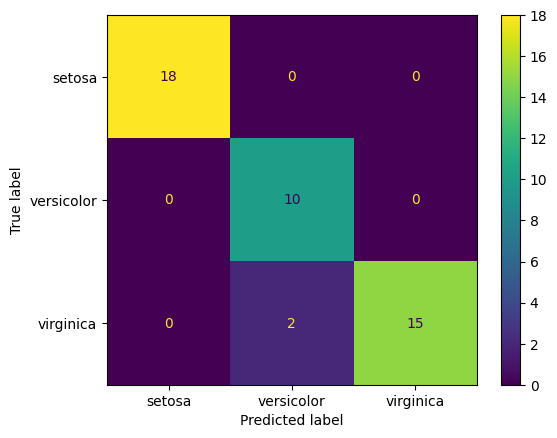

In [7]:
cm = confusion_matrix(y_test, y_pred_test)
ConfusionMatrixDisplay(cm, display_labels=target_names).plot();

In [9]:
# plot decision boundary

from sklearn.inspection import DecisionBoundaryDisplay

def plot_decision_boundary(X, y, clf, clf_name, feature_names=None, feature_index=None):

    if len(feature_names) != 2: raise ValueError(f"number of features in feature_names should be 2, {len(feature_names)} provided.")

    if "DataFrame" in str(type(X)):
        dataframe = True
    else:
        dataframe = False
        if len(feature_index) != 2: raise ValueError(f"Length of feature_index list should be 2, instead of {len(feature_index)}.")

    if dataframe:
        feature_1, feature_2 = np.meshgrid(
            np.linspace(X.loc[:, feature_names[0]].min(), X.loc[:, feature_names[0]].max(), 1000),
            np.linspace(X.loc[:, feature_names[1]].min(), X.loc[:, feature_names[1]].max(), 1000)
        )
    else:
        feature_1, feature_2 = np.meshgrid(
            np.linspace(X[:, feature_index[0]].min(), X[:, feature_index[0]].max(), 1000),
            np.linspace(X[:, feature_index[1]].min(), X[:, feature_index[1]].max(), 1000)
        )
    
    grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
    if dataframe:
        grid = pd.DataFrame(grid, columns=feature_names)

    if dataframe:
        clf.fit(X[feature_names], y)
    else:
        clf.fit(X[:,feature_index], y)

    y_pred = np.reshape(clf.predict(grid), feature_1.shape)

    display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=y_pred)
    display.plot()

    if dataframe:
        display.ax_.scatter(
            X.loc[:, feature_names[0]], X.loc[:, feature_names[1]], c=y, edgecolor="black"
        )
    else:
        display.ax_.scatter(
            X[:, feature_index[0]], X[:, feature_index[1]], c=y, edgecolor="black"
        )

    display.ax_.set_title(f"Decision Boundary of {clf_name} Classfier")
    display.ax_.set_xlabel(feature_names[0])
    display.ax_.set_ylabel(feature_names[1])
    plt.show()


In [10]:
feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

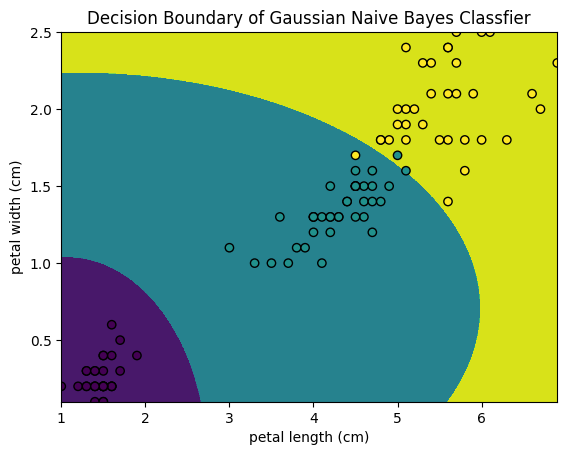

In [11]:
clf = NaiveBayes(nb_type='gaussian', feature_types={'numerical': feature_names[2:]})

plot_decision_boundary(X=X_train, y=y_train, clf=clf, clf_name="Gaussian Naive Bayes", feature_names=feature_names[2:])

Compare the decision boundary of naive bayes with the same with Logistic Regression 

In [12]:
from sklearn.linear_model import LogisticRegression

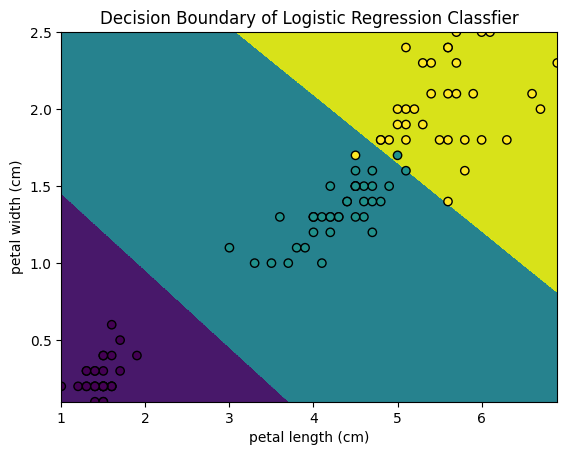

In [13]:
clf_lr = LogisticRegression(penalty=None, max_iter=1000)
plot_decision_boundary(X=X_train.values, y=y_train, clf=clf_lr, clf_name="Logistic Regression", 
                       feature_names=feature_names[2:], feature_index= [2,3])

### Gaussian Naive Bayes in sklearn

sklearn Naive Bayes documentation: 
- [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [CategoricalNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html#sklearn.naive_bayes.CategoricalNB)
- [BernoulliNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html)

User Guide: https://scikit-learn.org/stable/modules/naive_bayes.html#

In [14]:
from sklearn.naive_bayes import GaussianNB

clf_gnb_sk = GaussianNB()

clf_gnb_sk.fit(X_train, y_train)

,priors,None
,var_smoothing,1e-09


accuracy in test data: 0.9556
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.83      1.00      0.91        10
           2       1.00      0.88      0.94        17

    accuracy                           0.96        45
   macro avg       0.94      0.96      0.95        45
weighted avg       0.96      0.96      0.96        45



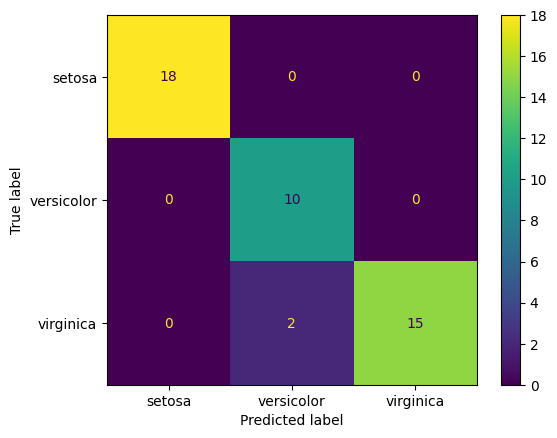

In [15]:
y_pred_test = clf_gnb_sk.predict(X_test)

print(f"accuracy in test data: {accuracy_score(y_test, y_pred_test):.4f}")

print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
ConfusionMatrixDisplay(cm, display_labels=target_names).plot();

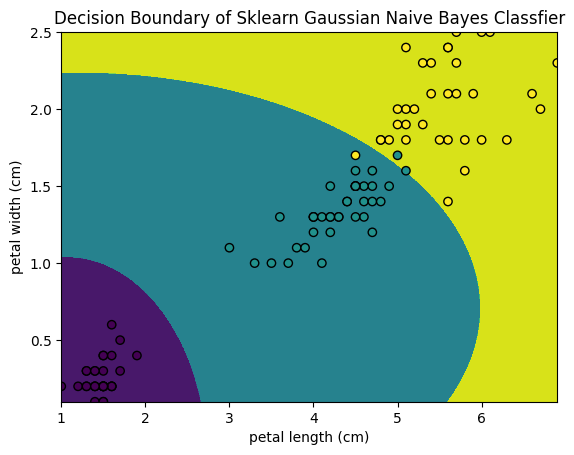

In [16]:
plot_decision_boundary(X=X_train, y=y_train, clf=clf_gnb_sk, clf_name="Sklearn Gaussian Naive Bayes", feature_names=feature_names[2:])

### Mobile Price Classification using Naive Bayes

The data is obtained from [mobile price classification dataset](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification) in kaggle. 

This dataset has 20 features, 1 target, and 2000 entries. The meanings of the features are given below.

**features:**
- *battery_power:* Total energy a battery can store in one time measured in mAh
- *blue:* Has bluetooth or not
- *clock_speed:* speed at which microprocessor executes instructions
- *dual_sim:* Has dual sim support or not
- *fc:* Front Camera mega pixels
- *four_g:* Has 4G or not
- *int_memory:* Internal Memory in Gigabytes
- *m_dep:* Mobile Depth in cm
- *mobile_wt:* Weight of mobile phone
- *n_cores:* Number of cores of processor
- *pc:* Primary Camera mega pixels
- *px_height:* Pixel Resolution Height
- *px_width:* Pixel Resolution Width
- *ram:* Random Access Memory in Mega Byte
- *sc_h:* Screen Height of mobile in cm
- *sc_w:* Screen Width of mobile in cm
- *talk_time:* longest time that a single battery charge will last when you are on call
- *three_g:* Has 3G or not
- *touch_screen:* Has touch screen or not
- *wifi:* Has wifi or not

**target**
- *price_range:* This is the target variable with value of 0(low cost), 1(medium cost), 2(high cost) and 3(very high cost).

In [17]:
# Set the option to display all columns
pd.set_option('display.max_columns', None)

mobile_price_dataset = pd.read_csv("./mobile_price_classification_dataset.csv")

In [18]:
mobile_price_dataset.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


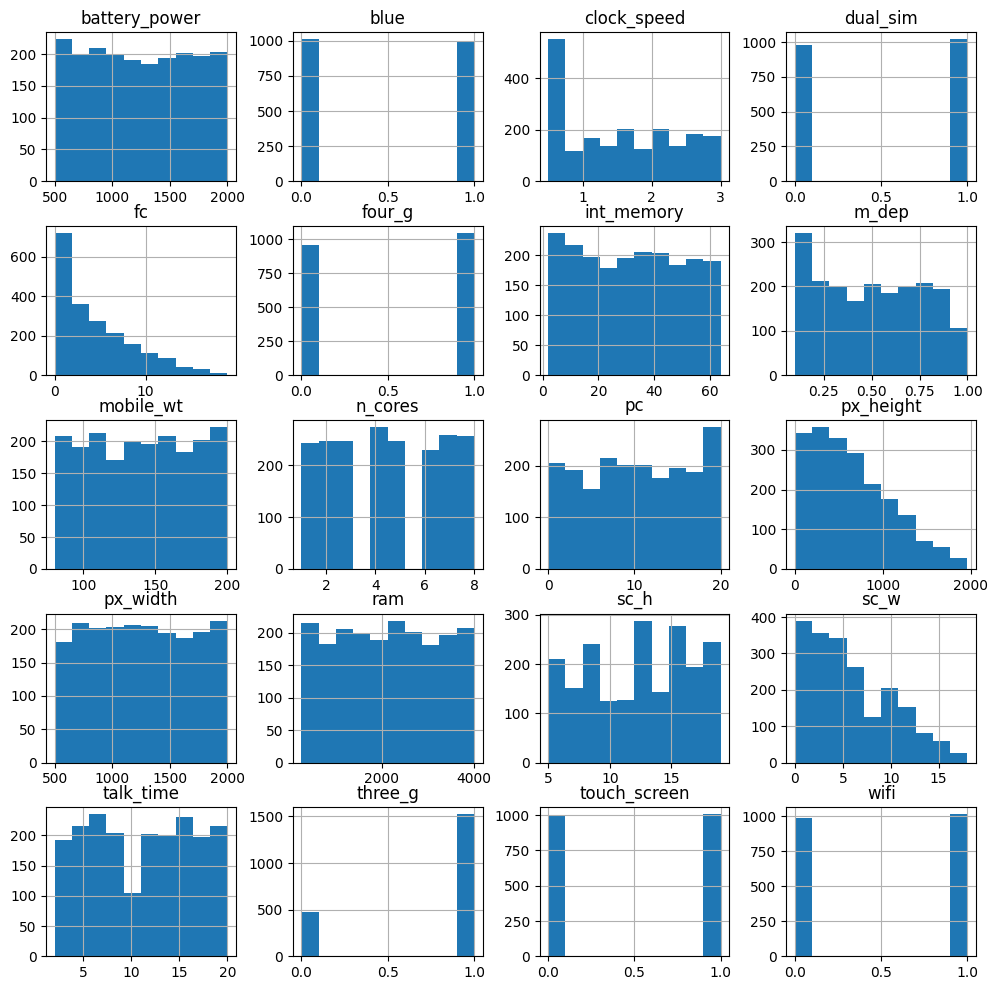

In [19]:
X = mobile_price_dataset.drop("price_range", axis = 1)
y = mobile_price_dataset['price_range'].values.flatten()

X.hist(figsize=(12,12));

In [20]:
numerical_cols = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'pc', 'px_height',
                  'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']

categorical_cols = ['n_cores']

boolean_cols = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']

feature_dict = {"numerical": numerical_cols,
                "categorical": categorical_cols,
                "boolean": boolean_cols
                }

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

X_train.shape, X_test.shape

((1500, 20), (500, 20))

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

In [24]:
preprocessor = ColumnTransformer(
                    transformers=[
                        ("standard_scaler", StandardScaler(), numerical_cols),
                        ("ordinal_encoder", OrdinalEncoder(), categorical_cols),
                        ("boolean_passthrough", 'passthrough', boolean_cols)
                    ]
                )

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [26]:
X_train = pd.DataFrame(X_train, columns=numerical_cols+categorical_cols+boolean_cols)
X_test = pd.DataFrame(X_test, columns=numerical_cols+categorical_cols+boolean_cols)

X_train.head()

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,n_cores,blue,dual_sim,four_g,three_g,touch_screen,wifi
0,-1.173599,-0.271513,1.299010,-0.892578,1.373998,-0.432510,1.330945,-0.530237,1.401689,-0.374710,-0.565657,-0.638397,-1.283645,0.0,1.0,1.0,0.0,0.0,1.0,1.0
1,-1.148540,0.952622,0.612430,0.380162,0.339707,1.344927,0.178279,1.173894,0.690329,1.429044,1.587251,-0.638397,0.723000,6.0,1.0,1.0,1.0,1.0,1.0,1.0
2,-1.474311,0.952622,-0.760731,1.597564,0.339707,0.554955,0.013612,-0.482837,-1.016473,-0.008093,0.151979,0.284587,-1.648489,3.0,1.0,1.0,0.0,1.0,0.0,1.0
3,0.391473,0.707795,1.299010,0.712181,1.373998,-1.448188,0.672279,-0.067526,-0.385950,1.677427,-1.044080,0.053841,-1.466067,4.0,1.0,1.0,0.0,0.0,0.0,1.0
4,-1.278393,0.952622,1.299010,1.542228,1.373998,0.103543,0.836945,-1.017776,-1.150431,-0.354546,-1.283292,-1.330635,0.358156,4.0,0.0,0.0,0.0,1.0,0.0,1.0


In [27]:
mixed_nb_clf = NaiveBayes(nb_type='mixed', feature_types=feature_dict, alpha=1)

mixed_nb_clf.fit(X_train, y_train)

# prediction on the test dataset
y_pred_test = mixed_nb_clf.predict(X_test)

accuracy in test data: 0.8000
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       119
           1       0.75      0.73      0.74       128
           2       0.72      0.67      0.70       137
           3       0.83      0.89      0.86       116

    accuracy                           0.80       500
   macro avg       0.80      0.81      0.80       500
weighted avg       0.80      0.80      0.80       500



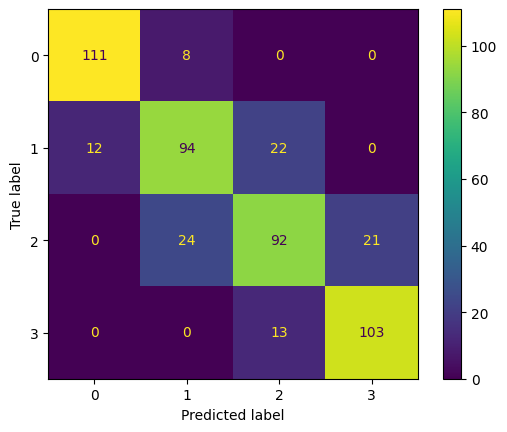

In [28]:
print(f"accuracy in test data: {accuracy_score(y_test, y_pred_test):.4f}")

print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
ConfusionMatrixDisplay(cm).plot();